### ****Финальный проект****
### Создание рекомендательной системы

#### Задача. 
1. Создание рекомендательной системы, благодаря которой можно будет предлагать клиентам интересные им курсы и тем самым повышать средний чек

#### Формализованные задачи:
1. Подготовить и проанализировать данные с помощью SQL.
2. Обработать данные средствами Python.
3. Составить итоговую таблицу с рекомендациями

In [4]:
import pandas as pd
import numpy as np
import psycopg2
import psycopg2.extras 
from collections import Counter
import itertools 

In [5]:
# Напишем фукцию для выгрузки данных из базы данных
def GetUsersAndCourses():
    query = '''with courses as
    (select c.user_id, ci.resource_id as course_id,
    count (ci.resource_id) over (partition by c.user_id) as col
    from final.carts as c 
    left join final.cart_items as ci on c.id = ci.cart_id
    where ci.resource_type = 'Course' and c.state = 'successful'
    group by c.user_id, ci.resource_id)
    Select  user_id, course_id from courses where col > 1
    '''.format()
    conn = psycopg2.connect("dbname='skillfactory' user='skillfactory' \
                            host='84.201.134.129' password='cCkxxLVrDE8EbvjueeMedPKt' port=5432")
    dict_cur = conn.cursor(cursor_factory=psycopg2.extras.DictCursor)
    dict_cur.execute(query)
    rows = dict_cur.fetchall()
    data = []
    for row in rows:
        data.append(dict(row))
    return data

# Создадим DataFrame с выгруженными данными
users_courses_df = pd.DataFrame(GetUsersAndCourses())
users_courses_df.head(5)

,user_id,course_id
0,51,516
1,51,1099
2,6117,356
3,6117,357
4,6117,1125


In [6]:
# Создадим перечень уникальных курсов
courses_set = sorted(set(users_courses_df['course_id']))

# Сгруппируем данные по пользователям и создадим столбец списка курсов, которые покупал каждый пользователь
users_courses_df = users_courses_df.groupby(['user_id'])['course_id'].apply(list).reset_index()
users_courses_df.head(5)

,user_id,course_id
0,51,"[516, 1099]"
1,6117,"[356, 357, 1125]"
2,10275,"[553, 1147]"
3,10457,"[361, 1138]"
4,17166,"[356, 357]"


In [7]:
# Создадим список всех возможных пар курсов, купленных одним пользователем
pairs = []
pairs.extend(users_courses_df['course_id'].apply(lambda x: list(itertools.combinations(x,2))))
pairs_list = list(itertools.chain(*pairs))
pairs_list[1:10]

[(356, 357),
 (356, 1125),
 (357, 1125),
 (553, 1147),
 (361, 1138),
 (356, 357),
 (1125, 1140),
 (551, 745),
 (553, 745)]

In [8]:
# Создадим множество уникальных пар
pairs_set = set(pairs_list)

# Создадим счетчик пар: сколько раз встречается каждая пара
pairs_count = Counter(pairs_list)
display(pairs_count.most_common(10))

[((551, 566), 797),
 ((515, 551), 417),
 ((489, 551), 311),
 ((523, 551), 304),
 ((566, 794), 290),
 ((489, 515), 286),
 ((490, 566), 253),
 ((490, 551), 247),
 ((570, 752), 247),
 ((569, 572), 216)]

In [9]:
# Рассмотрим счетчик пар подробнее. Преобразуем значения счетчика в объект Series для удобства изучения
pairs_count_series = pd.Series(pairs_count.values())
pairs_count_series.describe()

count    3989.000000
mean       10.031838
std        26.355998
min         1.000000
25%         1.000000
50%         3.000000
75%         9.000000
max       797.000000
dtype: float64

Все уникальных пар 3989, максимально пара курсов встречается 797 раз, минимально 1. При этом среднее значение количества повторений пар 10, а третий квартиль (75%) находится на границе 9 повторений. Из этого следует, что 75% наблюдений находятся ниже уровня средней границы. Это свидетельствует об ассиметрии данных. Распределение далеко от нормального

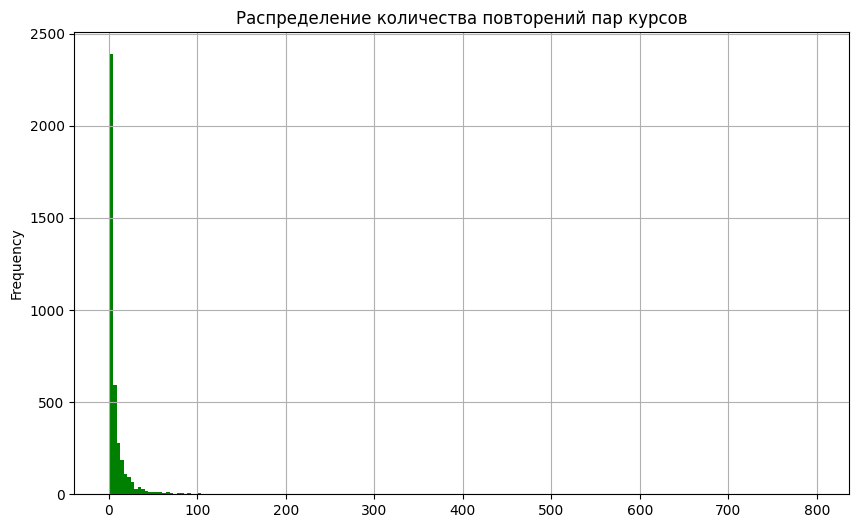

In [10]:
# Построим гистрограмму для наглядного отображения распределения количества повторений пар курсов
pairs_count_series.plot(
    kind='hist',
    figsize=(10, 6),
    title='Распределение количества повторений пар курсов',
    grid=True,
    color='green',
    bins=200
);

Гистограмма подтверждает вычисления: наибольшая часть количества повторений находится в диапазоне от 1 до 10

In [11]:
# Рассчитаем, сколько пар повторяются только 1 раз
pairs_count_series.value_counts().nlargest(10)

1     1185
2      578
3      366
4      259
5      202
7      148
6      148
8       95
10      87
9       80
dtype: int64

1185 пар курсов встречаются всего 1 раз. Для более детального анализа не хватает данных о тематике курсов. Возможно, это курсы из разных предметных областей и их совместная покупка одним пользователем указывает на его специфические предпочтения, которые не являются статистически значимыми. В дальнейшем при составлении таблицы рекомендаций будем рассматривать только пары курсов, которые встречаются более 1 раза. 

In [12]:
def Get_Recommendation(course):
    """Функция для подбора двух рекомендаций к выбранному курсу"""
    recommend_list = []
    
    # Цикл по элементам (уникальным парам) счетчика пар
    for element in pairs_count.elements():
        if course == element[0]: # Находим нужную пару к переданному в функцию курсу
            val = [element[1], pairs_count[element]] # Создаем список из рекомендованного курса и количества повторений
            if val not in recommend_list: # Если рекомендованного курса нет в списке рекомендаций, то добавляем
                recommend_list.append(val)  
  
    # Проверяем на наличие рекомендаций к выбранному курсу, если рекомендаций нет или мало, 
    # то ищем заданный курс на втором месте в парах
    if len(recommend_list)<2: 
        for element in pairs_count.elements():
            if course == element[1]: # Находим нужную пару к переданному в функцию курсу
                val = [element[0], pairs_count[element]] # Список из рекомендованного курса и количества повторений
                if val not in recommend_list: # Если рекомендованного курса нет в списке рекомендаций, то добавляем
                    recommend_list.append(val)
    
    # Сортируем список рекомендаций по количеству вхождений курса
    recommend_list.sort(key=lambda x: x[1], reverse=True)    
    
    # Если количество повторений  меньше 2, то ищем рекомендации для первого в списке рекомендаций курса
    if recommend_list[0][1]<2 or len(recommend_list)<2: 
        other_reccommend = Get_Recommendation(recommend_list[0][0])   
        row = [course, other_reccommend[1], other_reccommend[2]]    
        return row 
    else:
        row = [course, recommend_list[0][0], recommend_list[1][0]] 
        return row 

In [13]:
recommendation_courses_df = pd.DataFrame(columns=['Course_id', 'Recommendation_1', 'Recommendation_2'])
# Перебираем все курсы из множества курсов
for course_id in courses_set:
    row = Get_Recommendation(course_id) # Получаем рекомендации
    if row is not None: 
        row_df = pd.DataFrame({'Course_id': row[0], 'Recommendation_1': row[1], 'Recommendation_2': row[2]}, index=[0])
        recommendation_courses_df = pd.concat([recommendation_courses_df, row_df], ignore_index=True)
    recommendation_courses_df.reset_index()
display(recommendation_courses_df)

,Course_id,Recommendation_1,Recommendation_2
0,356,571,357
1,357,571,1125
2,358,570,752
3,359,570,507
4,360,745,516
...,...,...,...
121,1188,1141,513
122,1198,571,551
123,1199,523,515
124,1200,1104,1103
